<font color ='blue' size = '12'>**Осадки**</fon>

Данные с конкурса (https://www.kaggle.com/competitions/playground-series-s5e3/сode)

# <font color ='blue' size = '7'>**Импорт и установка бибилиотек**</font>

In [120]:
from google.colab import drive
import json
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [121]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Kaggle_API/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s5e3
  else:
    !gdown 1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s5e3.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

In [122]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
playground-series-s5e3.zip: Skipping, found more recently modified local copy (use --force to force download)


##<font color = '5d98f0' size = '5'>На этих данных необходимо построить модель

In [123]:
df_train.head(10)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
9,9,10,1025.4,16.5,14.4,12.0,8.6,77.0,84.0,1.0,50.0,38.3,0


In [ ]:
# # @title pressure vs maxtemp

# from matplotlib import pyplot as plt
# df_train.plot(kind='scatter', x='pressure', y='maxtemp', s=32, alpha=.8)
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [125]:
pd.set_option('display.max_columns', 30)

##<font color = '5d98f0' size ='5'>Определим роли для независимых признаков

In [126]:
id = 'id' #  столбец ID
target = 'rainfall'  #  Целевая переменная

# <font color= 'blue' size = '7'>*EDA*</font>

##<font color = '5d98f0' size= '5'>Оценим размер dataset

In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [128]:
# Датасет занимает память 222.6 КВ и состоит из 13 столбцов 10 из котщрых с плавающей точкой

In [129]:
df_train.shape

(2190, 13)

In [130]:
df_train. corr()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,1.000000,0.153065,-0.008235,0.012590,0.014307,0.018708,0.006797,-0.029042,0.002226,-0.003022,-0.004223,0.020167,0.033674
day,0.153065,1.000000,0.005337,0.146294,0.153590,0.161475,0.137929,-0.074048,-0.048175,0.060936,0.024800,-0.000199,-0.000462
pressure,-0.008235,0.005337,1.000000,-0.800499,-0.816531,-0.814453,-0.817008,-0.119949,0.098600,-0.257163,-0.643293,0.266012,-0.049886
maxtemp,0.012590,0.146294,-0.800499,1.000000,0.982932,0.965529,0.906703,-0.072615,-0.289047,0.452387,0.662235,-0.354168,-0.079304
temparature,0.014307,0.153590,-0.816531,0.982932,1.000000,0.987150,0.933617,-0.025016,-0.249355,0.414019,0.668963,-0.342262,-0.049660
mintemp,0.018708,0.161475,-0.814453,0.965529,0.987150,1.000000,0.941342,0.009891,-0.219399,0.379497,0.663828,-0.328871,-0.026841
dewpoint,0.006797,0.137929,-0.817008,0.906703,0.933617,0.941342,1.000000,0.153390,-0.088446,0.249676,0.643073,-0.312179,0.081965
humidity,-0.029042,-0.074048,-0.119949,-0.072615,-0.025016,0.009891,0.153390,1.000000,0.584854,-0.541592,-0.012430,0.062285,0.454213
cloud,0.002226,-0.048175,0.098600,-0.289047,-0.249355,-0.219399,-0.088446,0.584854,1.000000,-0.805128,-0.127087,0.184698,0.641191
sunshine,-0.003022,0.060936,-0.257163,0.452387,0.414019,0.379497,0.249676,-0.541592,-0.805128,1.000000,0.272235,-0.241752,-0.555287


In [131]:
# Видим корреляцию dewpoint,maxtemp,temparature, mintemp

In [132]:
# Рассмотрим основные характеристики
df_train.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [133]:
# Проверим на дубликаты
df_train.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
2185,False
2186,False
2187,False
2188,False


In [134]:
# Проверим на пропуски
df_train.isna().sum()

,0
id,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0


В наших данных нет пропусков и дубликатов

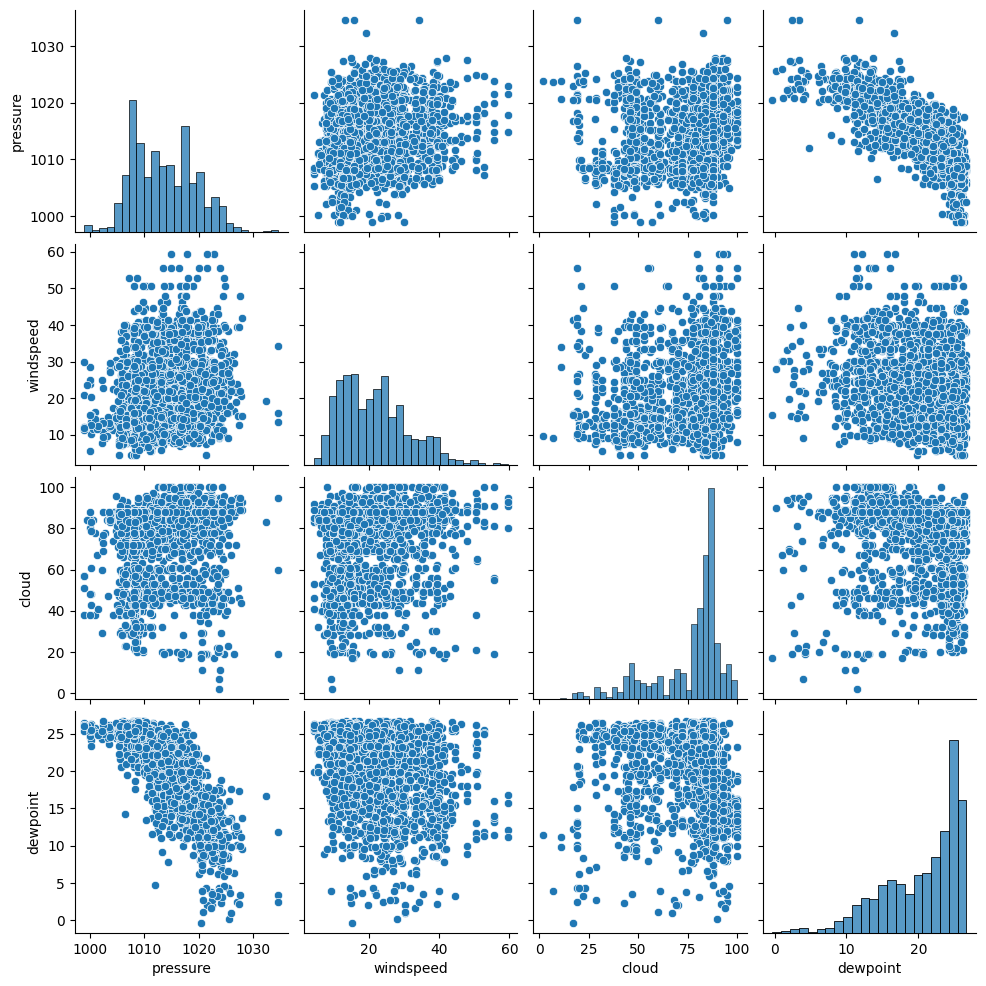

In [135]:
# Посмотрим график по некторым столбцам
column = ['pressure', 'windspeed', 'cloud','dewpoint']
sns.pairplot(df_train[column])
plt.show()

<Axes: xlabel='rainfall'>

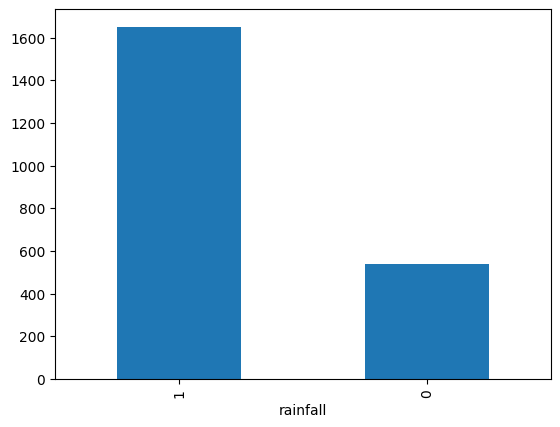

In [136]:
# Рассмотрим нашу целевую переменную на графике
df_train['rainfall'].value_counts().plot (kind='bar')

In [137]:
#  Удалим не нужный столбец
df_train_1=df_train.drop('id', axis = 1)

In [138]:
df_train_1.head(10)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
9,10,1025.4,16.5,14.4,12.0,8.6,77.0,84.0,1.0,50.0,38.3,0


#<font color = 'blue' size = '6'>**Разделим данные на test and train**</font>

In [139]:
X = df_train_1.drop(['rainfall','day'], axis =1)
y = df_train_1['rainfall']
test = df_test.drop(columns=["id",'day'])

In [140]:
# Подготовка тестового и тернировочного набора данных
X_train, X_test, y_train, y_train = train_test_split(X, y, test_size= 0.2, random_state = 42)

In [141]:
features_int = X.select_dtypes(include='float64').columns.to_list()
features_int

['pressure',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity',
 'cloud',
 'sunshine',
 'winddirection',
 'windspeed']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X[features_int], y, test_size=0.2, random_state=42)

#<font color= 'blue' size = '6'>**Построение моделей**</font>

#<font color = 'blue' size = '6'>**DecisionTreeClassifier**</font>

In [143]:
pipeline_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [144]:
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [145]:
y_pred = pipeline_tree.predict(X_test)
prediction = pipeline_tree.predict(X_test)
probability = pipeline_tree.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, prediction))
print("F1:", f1_score(y_test, prediction))
f1_clf = f1_score(y_test, prediction)

Accuracy: 0.7945205479452054
F1: 0.860248447204969


#<font color = 'blue' size= '6'>**RandomForest**</font>

In [146]:
rf= RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [147]:
y_pred = pipeline_tree.predict(X_test)
prediction = pipeline_tree.predict(X_test)
probability = pipeline_tree.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, prediction))
print("F1:", f1_score(y_test, prediction))
f1_rf = f1_score(y_test, prediction)

Accuracy: 0.7945205479452054
F1: 0.860248447204969


##<font color ='5d98f0' size = '5'>Feature Selection

In [148]:
feature_names= X.columns

In [149]:
importances = rf.feature_importances_

In [150]:
indices= np.argsort(importances)[::-1]

print('Feature importances:')
for f, idx in enumerate(indices):
  print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'cloud' (0.3119)
 2. feature 'sunshine' (0.1893)
 3. feature 'humidity' (0.0906)
 4. feature 'dewpoint' (0.0707)
 5. feature 'windspeed' (0.0640)
 6. feature 'pressure' (0.0599)
 7. feature 'temparature' (0.0589)
 8. feature 'mintemp' (0.0568)
 9. feature 'maxtemp' (0.0567)
10. feature 'winddirection' (0.0413)


In [151]:
best_features = indices[:10]
best_features_names = feature_names[best_features]
print(best_features_names)

Index(['cloud', 'sunshine', 'humidity', 'dewpoint', 'windspeed', 'pressure',
       'temparature', 'mintemp', 'maxtemp', 'winddirection'],
      dtype='object')


In [ ]:
# d_first = 10
# plt.figure(figsize=(8, 8))
# plt.title("Feature importances")
# plt.bar(range(d_first), importances[indices[:d_first]], align='center')
# plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
# plt.xlim([-1, d_first]);

#<font color ='blue' size = '6'>**GradientBoosting**</font>

In [153]:
gbt= ensemble.GradientBoostingClassifier(n_estimators = 100, random_state= 11)

In [154]:
# Построим модель со занчимыми признакми
gbt.fit(X_train[best_features_names], y_train)

GradientBoostingClassifier(random_state=11)

In [155]:
y_pred = gbt.predict(X_test[best_features_names])
prediction = gbt.predict(X_test[best_features_names])
probability = gbt.predict_proba(X_test[best_features_names])[:, 1]
print("Accuracy:", accuracy_score(y_test, prediction))
print("F1:", f1_score(y_test, prediction))
f1_gbt = f1_score(y_test, prediction)

Accuracy: 0.8538812785388128
F1: 0.9036144578313253


#<font color = 'blue' size = '6'>Сonclusion

In [156]:
pd.DataFrame(data = [f1_clf, f1_rf, f1_gbt], columns=["F1"], index = ["DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier"])


,F1
DecisionTreeClassifier,0.860248
RandomForestClassifier,0.860248
GradientBoostingClassifier,0.903614


#<font color= 'blue' size = '6'>**Submission**</font>

In [157]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [158]:
df_test.head(10)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
5,2195,6,1027.1,15.6,12.6,11.5,9.0,76.0,94.0,0.0,20.0,41.4
6,2196,7,1022.6,15.5,13.7,10.7,11.8,79.0,95.0,0.0,20.0,43.1
7,2197,8,1013.5,20.5,16.2,15.2,13.1,94.0,93.0,0.2,70.0,41.3
8,2198,9,1021.3,16.3,13.2,11.3,10.8,85.0,99.0,0.1,20.0,34.0
9,2199,10,1026.1,10.4,8.5,7.0,3.1,69.0,88.0,0.0,20.0,26.4


In [159]:
df_test.isna().sum()

,0
id,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0


In [160]:
#  Числовой столбец с пропускаим у нас 1, заменим пропуски на среднее занчение
df_test['winddirection'].fillna(df_test['winddirection'].mean(), inplace=True)

<ipython-input-160-d216e1c51408>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['winddirection'].fillna(df_test['winddirection'].mean(), inplace=True)


In [161]:
test.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [108]:
submit_score = []

In [164]:
pred = gbt.predict_proba(test_scaled)[:,1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [166]:
# submit= pd.read_csv('../input/playground-series-s5e3/sample_submission.csv')
#submission
df_sample_submission['rainfall'] = pred
df_sample_submission.to_csv('submission_svm.csv', index=False)
df_sample_submission.head()

,id,rainfall
0,2190,0.126748
1,2191,0.126748
2,2192,0.126748
3,2193,0.126748
4,2194,0.126748
